# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [1]:
# imports
from hmmlearn import hmm
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [2]:
# Load in data

# Data Engineering

Initial exploration shown to be promising.
Now do some data engineering to get the targets into the format I want.

In [3]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

df_m_lab

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 179048
Percentage duplicate: 21.701656762132398


,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
3,alloc-slider-5,1.176995,ID1
4,alloc-slider-5,1.790000,ID1
5,html,2.896995,ID1
...,...,...,...
58261,alloc-slider-2,273.796495,ID18
58263,alloc-slider-2,273.836415,ID18
58265,alloc-slider-2,273.924560,ID18
58270,html,274.968440,ID18


In [4]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)
data_turk.shape

(645995, 1)

In [5]:
# we want to have everything in one long array like this.
# But then we need to create the lengths array thing.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

lab_lengths

[2267,
 2341,
 2341,
 646,
 597,
 3116,
 1531,
 490,
 2666,
 469,
 3754,
 3754,
 2005,
 2005]

In [6]:
# Create Lab data HMM

# Suggestions for number of hidden states.
# https://www.researchgate.net/post/Is_there_any_simple_rule_for_the_number_of_states_in_HMM

# Picked 6 hidden states as thats what the actual system has. sliders 1-5 and other
lab_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_lab, lab_lengths) # dont know how many components/hidden states I should have
lab_model

1      -56759.1163             +nan
         2      -47711.6643       +9047.4520
         3      -40440.3305       +7271.3338
         4      -36838.0855       +3602.2450
         5      -33898.1212       +2939.9643
         6      -25847.4826       +8050.6386
         7       -8453.8532      +17393.6294
         8       39070.2581      +47524.1114
         9       56067.9756      +16997.7174
        10       99424.0314      +43356.0558


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [7]:
lab_model.sample(10)

(array([[ 0.09108383],
        [-0.04838295],
        [ 5.00276648],
        [ 4.99847626],
        [ 5.0010654 ],
        [ 5.00039767],
        [ 5.00178817],
        [ 4.99963452],
        [ 4.999989  ],
        [ 5.00089955]]),
 array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1]))

In [8]:
# Lab Transition Matrix
np.round(lab_model.transmat_, 3)

array([[0.948, 0.004, 0.012, 0.015, 0.02 , 0.002],
       [0.006, 0.948, 0.015, 0.005, 0.005, 0.021],
       [0.013, 0.018, 0.913, 0.025, 0.015, 0.015],
       [0.027, 0.005, 0.017, 0.941, 0.007, 0.003],
       [0.018, 0.005, 0.011, 0.005, 0.942, 0.019],
       [0.002, 0.019, 0.014, 0.001, 0.012, 0.953]])

In [9]:
turk_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_turk.reshape(-1, 1), turk_lengths) # dont know how many components/hidden states I should have
turk_model

1    -1348114.5762             +nan
         2    -1156449.4822     +191665.0940
         3     -969970.4722     +186479.0100
         4     -881383.5846      +88586.8876
         5     -812158.1284      +69225.4563
         6     -646277.2357     +165880.8927
         7     -421044.8863     +225232.3494
         8      246386.2088     +667431.0951
         9     1648045.7000    +1401659.4912
        10     3913271.3959    +2265225.6959


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [10]:
# Show transition matrix of hidden states.
# TODO: compute actual system trasitions with n-grams.

np.round(turk_model.transmat_, 2)

array([[0.94, 0.02, 0.01, 0.  , 0.02, 0.01],
       [0.02, 0.93, 0.02, 0.01, 0.01, 0.02],
       [0.  , 0.02, 0.95, 0.01, 0.  , 0.01],
       [0.  , 0.02, 0.02, 0.95, 0.  , 0.  ],
       [0.01, 0.02, 0.  , 0.  , 0.95, 0.  ],
       [0.02, 0.03, 0.01, 0.  , 0.  , 0.93]])

In [11]:
# Create a new data samples of length 10.

np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)


array([1., 1., 1., 1., 1., 1., 2., 1., 1., 1.])

In [12]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[15312.260916096107,
 15922.992247965289,
 15925.355693429408,
 4293.603885650873,
 4070.928456410289,
 21214.91820972194,
 10513.856235061654,
 3378.3496645127166,
 18093.405880881928,
 3179.219312986357,
 25613.749790037364,
 25573.29328076893,
 13586.83228149157,
 13596.534633489484]

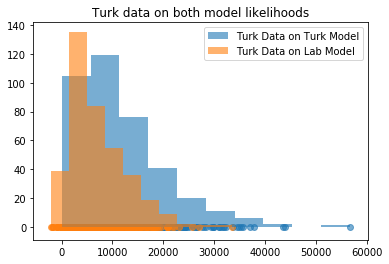

In [13]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

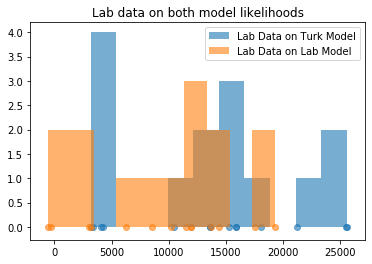

In [14]:
lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

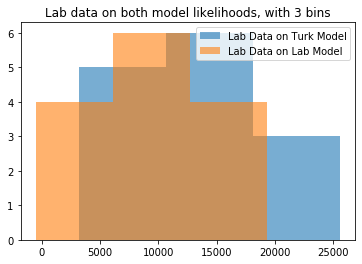

In [15]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

plt.hist(lab_data_turk_model, bins=3, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=3, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods, with 3 bins')
plt.legend(loc='best')
plt.show()

In [16]:
print(lab_model.score(data_lab, lab_lengths))
print(turk_model.score(data_lab, lab_lengths))
print()
print(lab_model.score(data_turk, turk_lengths))
print(turk_model.score(data_turk, turk_lengths))

135568.91802917558
191802.04306972848

2852869.4636455826
4443018.002353924


In [17]:
lab_data_turk_model
lab_data_lab_model
turk_data_turk_model
turk_data_lab_model 

[1868.9064738267948,
 3180.6845184890876,
 3661.7013142807914,
 4177.451527515787,
 1460.0478978943904,
 1510.9293736153345,
 3540.1244816872495,
 12800.151728402776,
 1859.6519505808353,
 3539.3834309001063,
 10358.714359412692,
 1415.4498951209766,
 1900.5642102137735,
 3998.3074160419774,
 6410.910159520517,
 -882.6221049056513,
 1664.5189981235953,
 2866.3968248470273,
 2424.3454367434897,
 7128.488996096061,
 14269.411152631881,
 13040.181103227056,
 4020.5296218534477,
 2103.136345043426,
 14185.140924131538,
 2821.5135566829304,
 8980.19147590457,
 8110.0514656225,
 14553.92540124054,
 1920.7506876048012,
 3224.20447207402,
 1132.624675405178,
 19531.49061615953,
 2148.1555040870203,
 -320.20004058904357,
 6475.174088972579,
 16425.845228452712,
 3907.974495286681,
 13698.272713996446,
 20973.892216896205,
 4667.800344705379,
 8578.056031508457,
 5467.45503460221,
 14679.178698042784,
 1152.4516254283785,
 14640.566818576675,
 4693.050769330646,
 8330.764359918046,
 16731.673411

# Plotting results

It is hard to visulaise these results, so show them as a scatter point and a 2D histogram.
A straight line of y = x will be shown.
A point on this line will have the identily likelihoods to belong to either model.



(0, 60000)

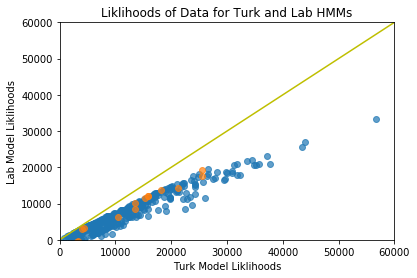

In [18]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7)
plt.plot(range(60000), c='y')
plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
plt.xlim(0, 60000)
plt.ylim(0, 60000)
# TODO: Create a 2d histogram to better show the distribution.
# TODO: Make x and y same size and scale, while plotting a straight line of y=x 

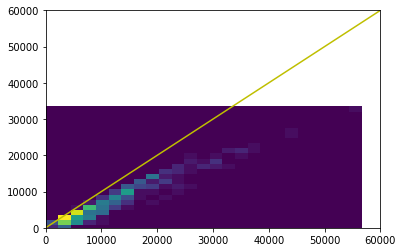

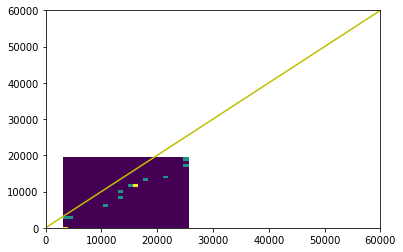

In [19]:
plt.hist2d(turk_data_turk_model, turk_data_lab_model, bins=25);
plt.xlim(0, 60000)
plt.ylim(0, 60000)
plt.plot(range(60000), c='y')
plt.show()

plt.hist2d(lab_data_turk_model, lab_data_lab_model, bins=25);
plt.xlim(0, 60000)
plt.ylim(0, 60000)
plt.plot(range(60000), c='y')
plt.show()

# Reassigning samples

Now run all lab and turk data through both models. 
Assign a predicted label (lab / online) data.
Afterwards compare actual and predicted to see if any samples seem to be missclassified.  

In [20]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def reclassify_samples(turk_model, lab_model, data, lengths):
    # Given a model and some data and lengths return a list of predicted new classes.

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

    return new_classes

reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)    # Try lab data

User 0: 	 turk: 15312, 	 lab: 11504
User 1: 	 turk: 15922, 	 lab: 11965
User 2: 	 turk: 15925, 	 lab: 11967
User 3: 	 turk: 4293, 	 lab: 3179
User 4: 	 turk: 4070, 	 lab: 3068
User 5: 	 turk: 21214, 	 lab: 14385
User 6: 	 turk: 10513, 	 lab: 6266
User 7: 	 turk: 3378, 	 lab: -315
User 8: 	 turk: 18093, 	 lab: 13686
User 9: 	 turk: 3179, 	 lab: -532
User 10: 	 turk: 25613, 	 lab: 19323
User 11: 	 turk: 25573, 	 lab: 17532
User 12: 	 turk: 13586, 	 lab: 8532
User 13: 	 turk: 13596, 	 lab: 10210


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [21]:
reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try turk data

User 0: 	 turk: 2466, 	 lab: 1868
User 1: 	 turk: 4223, 	 lab: 3180
User 2: 	 turk: 6966, 	 lab: 3661
User 3: 	 turk: 5594, 	 lab: 4177
User 4: 	 turk: 2000, 	 lab: 1460
User 5: 	 turk: 2946, 	 lab: 1510
User 6: 	 turk: 5630, 	 lab: 3540
User 7: 	 turk: 17398, 	 lab: 12800
User 8: 	 turk: 6809, 	 lab: 1859
User 9: 	 turk: 4569, 	 lab: 3539
User 10: 	 turk: 14865, 	 lab: 10358
User 11: 	 turk: 2806, 	 lab: 1415
User 12: 	 turk: 6363, 	 lab: 1900
User 13: 	 turk: 5233, 	 lab: 3998
User 14: 	 turk: 12529, 	 lab: 6410
User 15: 	 turk: 2721, 	 lab: -882
User 16: 	 turk: 6057, 	 lab: 1664
User 17: 	 turk: 3786, 	 lab: 2866
User 18: 	 turk: 3245, 	 lab: 2424
User 19: 	 turk: 10492, 	 lab: 7128
User 20: 	 turk: 19483, 	 lab: 14269
User 21: 	 turk: 22616, 	 lab: 13040
User 22: 	 turk: 11347, 	 lab: 4020
User 23: 	 turk: 2976, 	 lab: 2103
User 24: 	 turk: 20129, 	 lab: 14185
User 25: 	 turk: 4145, 	 lab: 2821
User 26: 	 turk: 14168, 	 lab: 8980
User 27: 	 turk: 11213, 	 lab: 8110
User 28: 	 turk

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Turk likelihoods  Lab likelihoods   Difference   ID
0      15312.260916     11504.840623  3807.420293  ID1
1      15922.992248     11965.638879  3957.353369  ID2
2      15925.355693     11967.170294  3958.185399  ID3
3       4293.603886      3179.095060  1114.508826  ID4
4       4070.928456      3068.238735  1002.689721  ID5


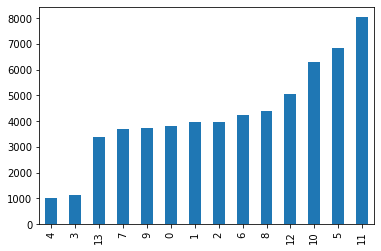

In [22]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_m_lab['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

Turk likelihoods  Lab likelihoods   Difference              ID
0       2466.191347      1868.906474   597.284873  A35YFAFWP33C70
1       4223.832196      3180.684518  1043.147678  A33XI8ZN4NZ0SQ
2       6966.918787      3661.701314  3305.217472  A1ZG7VYH0DUEXW
3       5594.053930      4177.451528  1416.602402  A1RXG8RE0SJ4LC
4       2000.445054      1460.047898   540.397156  A3BGIK3STL9345


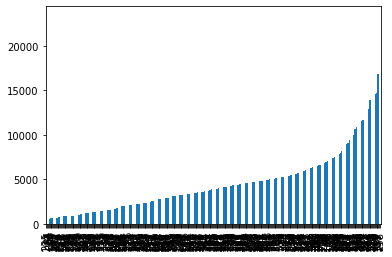

In [23]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_m_turk['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

# Link between length of mouse events and likelihood?

From an breif exploration of the likelihoods and through tableau it looks like the users with longer sequences have mainly high likelihoods for turk data, and shorter sequences have higher likelihood for lab data.

Plot likelihood difference and length of mouse evetns to see if there is actually a strong correlation.



In [24]:
df_turk_diff['Turk likelihoods']

0       2466.191347
1       4223.832196
2       6966.918787
3       5594.053930
4       2000.445054
           ...     
376       39.652174
377    12090.285311
378     9808.068129
379     2283.716443
380    16929.445143
Name: Turk likelihoods, Length: 381, dtype: float64

In [25]:
np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(1,-1)

array([[2.46619135e+03, 4.22383220e+03, 6.96691879e+03, 5.59405393e+03,
        2.00044505e+03, 2.94600650e+03, 5.63081106e+03, 1.73986583e+04,
        6.80921526e+03, 4.56931011e+03, 1.48651490e+04, 2.80660276e+03,
        6.36395183e+03, 5.23393512e+03, 1.25296822e+04, 2.72184031e+03,
        6.05711885e+03, 3.78601247e+03, 3.24533003e+03, 1.04924646e+04,
        1.94830105e+04, 2.26167066e+04, 1.13470102e+04, 2.97646579e+03,
        2.01297270e+04, 4.14525275e+03, 1.41682041e+04, 1.12136402e+04,
        2.16716276e+04, 6.46887678e+03, 4.21192279e+03, 3.70072737e+03,
        2.65268663e+04, 2.75618258e+03, 3.42106127e+03, 8.46438498e+03,
        2.35325384e+04, 6.23993729e+03, 1.87501472e+04, 3.56914777e+04,
        1.02022836e+04, 1.27791813e+04, 7.34225905e+03, 1.99216001e+04,
        1.75391925e+03, 1.98211238e+04, 1.10189592e+04, 1.15213870e+04,
        2.75608339e+04, 9.33949191e+03, 3.53634764e+03, 1.54262548e+04,
        8.92519626e+03, 8.61716670e+03, 2.98199290e+04, 7.553662

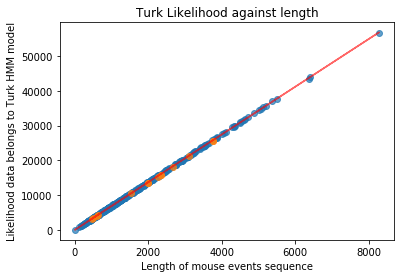

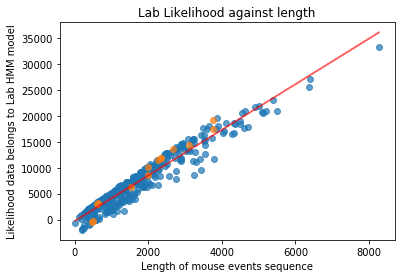

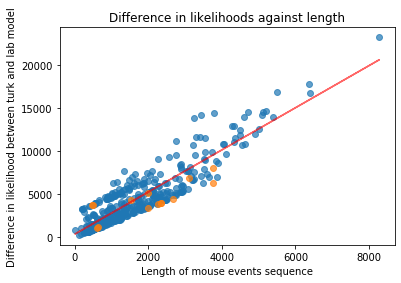

In [62]:
from sklearn.linear_model import LinearRegression

# Turk plot
plt.scatter(turk_lengths, df_turk_diff['Turk likelihoods'], alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], alpha=0.7)
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Lab plot
plt.scatter(turk_lengths, df_turk_diff['Lab likelihoods'], alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], alpha=0.7)
plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Difference plot
plt.scatter(turk_lengths, df_turk_diff['Difference'], alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Difference'], alpha=0.7)
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.array(turk_lengths+lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

In [63]:
from scipy.stats import norm

In [64]:
# See if lab_lengths follow a normal distribution
# Lab lengths kind of follow this distribution but not really.
#https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
'''
from scipy.stats import norm
from scipy.stats import lognorm

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

mu, std = norm.fit(turk_lengths)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

#dist=lognorm([std],loc=mean)
lognorm_dist = lognorm(s=std, loc=mu)
p2 = lognorm(*lnorm)

plt.plot(x, lognorm_dist.pdf(x), 'y', linewidth=2)

title = "Turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()



from scipy.stats import norm

data = turk_lengths
ogdata = np.log(data)
estimated_mu, estimated_sigma = norm.fit(logdata)

x = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')


# plot histogram in log space
logdata = np.log(data)
plt.hist(logdata, bins=25)


shape,loc,scale = lognorm.fit(data)

x = np.logspace(0, 5, 200)
pdf = lognorm.pdf(x, shape, loc, scale)

plt.plot(x, pdf, 'r')

''';

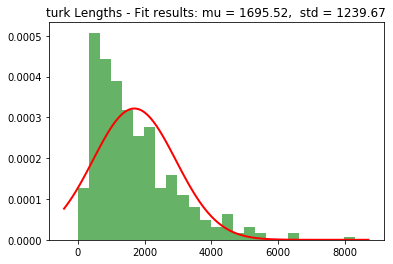

In [65]:
# See if turk data follows a distrinution

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

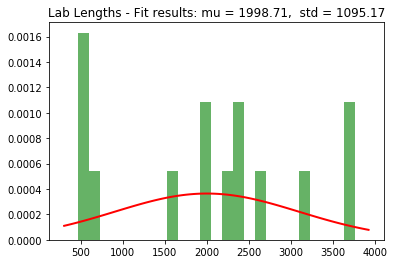

In [66]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

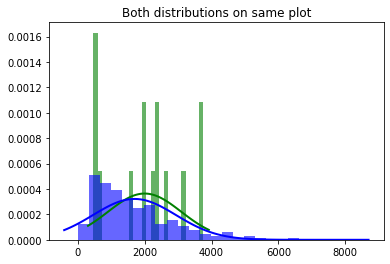

In [100]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'b', linewidth=2)

plt.show()

Text(0.5, 1.0, 'Both Lengths - Fit results: mu = 1706.27,  std = 1236.11')

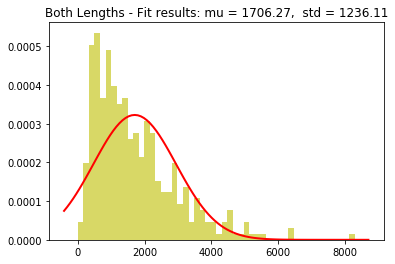

In [102]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=50, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Thought this would be a failure at first but this is actually really amazing!
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

At the moment this section creates fixed length samples but that will change.

In [69]:
# Sample points from distributions of lengths, using their mean, and sd.

num_generated_samples = 100

# Wanna generate lab sequences as thats the smaller class.
mu, std = norm.fit(lab_lengths)
generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)   # Creating 300 more samples would make the classes even ish.

# https://stackoverflow.com/a/38406535/11902832
# Remove negative values, but now its not really a normal distribution
generated_lengths = abs(generated_lengths).astype(int)



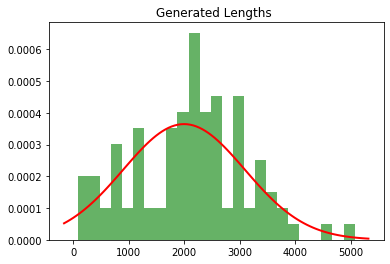

In [70]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(generated_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Generated Lengths "
plt.title(title)

plt.show()

In [71]:
created_data = []
for i in generated_lengths:

    X, Z = lab_model.sample(i)  # This generates a new sample, length of which is taken from the normal distribution

    created_data.append( np.concatenate(X).ravel().astype(int).astype(str).tolist() ) # list of nps flattened, and to ints

len(created_data)

100

In [72]:
# we have array of length 100, each of which contains events of varing lengths.

IDs = []    # This will be the length of the flattened array. will be like ID1, ID1, ID2 etc
targets = []

for i in range(len(created_data)):    
    targets.extend(created_data[i])

    for j in range(len(created_data[i])):
        IDs.append(f'ID{i}')


In [73]:
df = pd.DataFrame({'target':targets, 'turkId':IDs}) 
df.astype(object)
#df['target'] = df['target'].rename({'0' :'html', '1':'Slider-1', '2':'Sliders-2', '3':'Slider-3', '4':'Slider-4', '5':'Slider-5'})

df['target'] = df['target'].replace('0','html')
df['target'] = df['target'].replace('1','alloc-slider-1')
df['target'] = df['target'].replace('2','alloc-slider-2')
df['target'] = df['target'].replace('3','alloc-slider-3')
df['target'] = df['target'].replace('4','alloc-slider-4')
df['target'] = df['target'].replace('5','alloc-slider-5')

df

,target,turkId
0,html,ID0
1,html,ID0
2,html,ID0
3,html,ID0
4,alloc-slider-3,ID0
...,...,...
211178,alloc-slider-4,ID99
211179,alloc-slider-3,ID99
211180,alloc-slider-4,ID99
211181,alloc-slider-3,ID99


In [74]:
df.to_csv('created_labs.csv')

Tableau images https://imgur.com/a/FagaiQW
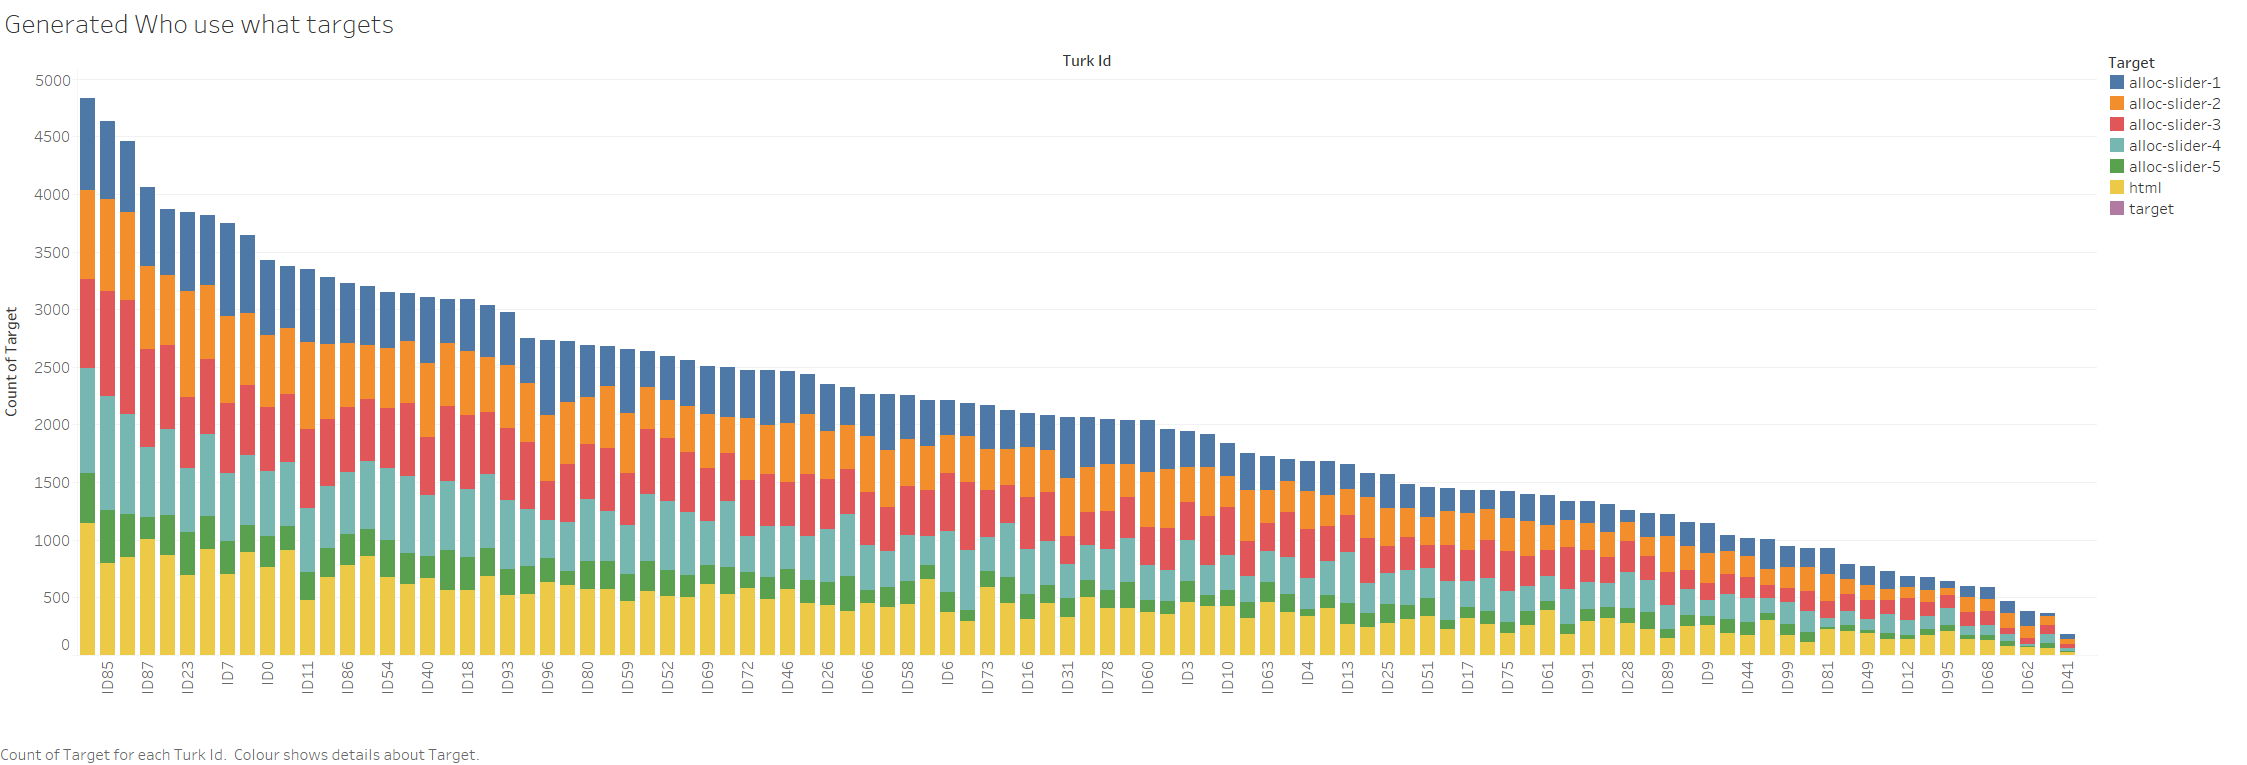

Now weve generated some more data samples see if the generated data sampels would be identified by the lab hmm not the turk hmm.



In [75]:
flatten_created_data = np.concatenate(created_data).ravel().astype(int).reshape(-1,1)

# STILL PREDICTS EVERYTHING AS LAB!

reclassify_samples(turk_model, lab_model, flatten_created_data, generated_lengths)    # Try generated lab data

User 0: 	 turk: 2084, 	 lab: 1369
User 1: 	 turk: 6493, 	 lab: 3776
User 2: 	 turk: 9664, 	 lab: 4915
User 3: 	 turk: 11826, 	 lab: 6666
User 4: 	 turk: 1730, 	 lab: 957
User 5: 	 turk: 11420, 	 lab: 6009
User 6: 	 turk: 17610, 	 lab: 7096
User 7: 	 turk: 1207, 	 lab: 589
User 8: 	 turk: 15253, 	 lab: 6059
User 9: 	 turk: 13592, 	 lab: 7678
User 10: 	 turk: 8842, 	 lab: 4129
User 11: 	 turk: 12952, 	 lab: 7288
User 12: 	 turk: 10197, 	 lab: 5625
User 13: 	 turk: 4041, 	 lab: 642
User 14: 	 turk: 17339, 	 lab: 9841
User 15: 	 turk: 12541, 	 lab: 5359
User 16: 	 turk: 10494, 	 lab: 5021
User 17: 	 turk: 23789, 	 lab: 13299
User 18: 	 turk: 4169, 	 lab: 2375
User 19: 	 turk: 534, 	 lab: -2696
User 20: 	 turk: 6921, 	 lab: 1236
User 21: 	 turk: 14608, 	 lab: 8301
User 22: 	 turk: 17000, 	 lab: 9666
User 23: 	 turk: 10730, 	 lab: 5944
User 24: 	 turk: 11851, 	 lab: 3707
User 25: 	 turk: 15635, 	 lab: 7997
User 26: 	 turk: 18652, 	 lab: 9629
User 27: 	 turk: 15319, 	 lab: 8531
User 28: 	 tur

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [76]:
#idea: maybe the liklihoods are messed up because of the inbalanece in training size when orriginally training?
# Try duplicating training samples NOW, or retrain on the created data.

generated_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(flatten_created_data, generated_lengths.tolist()) # not sure why not working.
generated_model

1     -426879.0019             +nan
         2     -359869.3706      +67009.6313
         3     -310977.5153      +48891.8553
         4     -286789.7923      +24187.7230
         5     -271849.1863      +14940.6061
         6     -249920.5509      +21928.6354
         7     -230513.2581      +19407.2928
         8     -216902.1205      +13611.1375
         9     -207605.5549       +9296.5657
        10     -195081.0235      +12524.5314


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [77]:
reclassify_samples(turk_model, generated_model, flatten_created_data, generated_lengths) 

User 0: 	 turk: 2084, 	 lab: -370
User 1: 	 turk: 6493, 	 lab: -884
User 2: 	 turk: 9664, 	 lab: -1393
User 3: 	 turk: 11826, 	 lab: -1732
User 4: 	 turk: 1730, 	 lab: -217
User 5: 	 turk: 11420, 	 lab: -1643
User 6: 	 turk: 17610, 	 lab: -2587
User 7: 	 turk: 1207, 	 lab: -147
User 8: 	 turk: 15253, 	 lab: -2237
User 9: 	 turk: 13592, 	 lab: -1972
User 10: 	 turk: 8842, 	 lab: -1304
User 11: 	 turk: 12952, 	 lab: -1874
User 12: 	 turk: 10197, 	 lab: -1496
User 13: 	 turk: 4041, 	 lab: -605
User 14: 	 turk: 17339, 	 lab: -2471
User 15: 	 turk: 12541, 	 lab: -1809
User 16: 	 turk: 10494, 	 lab: -1523
User 17: 	 turk: 23789, 	 lab: -3407
User 18: 	 turk: 4169, 	 lab: -606
User 19: 	 turk: 534, 	 lab: -10
User 20: 	 turk: 6921, 	 lab: -1020
User 21: 	 turk: 14608, 	 lab: -2121
User 22: 	 turk: 17000, 	 lab: -2496
User 23: 	 turk: 10730, 	 lab: -1559
User 24: 	 turk: 11851, 	 lab: -1733
User 25: 	 turk: 15635, 	 lab: -2272
User 26: 	 turk: 18652, 	 lab: -2637
User 27: 	 turk: 15319, 	 lab:

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# NLP methods again 

See if the naive bayes of n-grams distribution will work better.

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [130]:
def make_cm(cm):
    # Makes a confustion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.suptitle('0=online, 1=lab')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [79]:
created_data

 '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '1',
  '0',
  '0',
  '1',
  '0',
  '0',
  '1',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '5',
  '4',
  '4',
  '5',
  '5',
  '4',
  '5',
  '5',
  '5',
  '5',
  '4',
  '5',
  '4',
  '4',
  '4',
  '5',
  '4',
  '5',
  '5',
  '4',
  '4',
  '4',
  '5',
  '5',
  '4',
  '5',
  '4',
  '5',
  '4',
  '5',
  '4',
  '5',
  '5',
  '5',
  '4',
  '4',
  '4',
  '5',
  '4',
  '4',
  '5',
  '4',
  '5',
  '5',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '3',
  '2',
  '3',
  '3',
  '3',
  '3',
  '2',
  '2',
  '3',
  '2',
  '2',
  '2',
  '3',
  '3',
  '3',
  '3',
  '2',
  '3',
  '2',
  '2',
  '2',
  '2',
  '3',
  '3',
  '2',
  '2',
  '3',
  '3',
  '3',
  '2',
  '2',
  '3',
  '3',
  '3',
  '4',
  '4',
  '3',
  '3',
  '4',
  '4',
  '4',
  '4',
  '4',
  '3',
  '4',
  '4',
  '4',
  '3',
  '3',
  '2',
  '2',
  '3',
  '3',
  '3',
  '2',
  '3',
  '3',
  '3',
  '3',
  '2',
  '2',
  '2',
  '2',


In [80]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ','.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
generated_targets = targets_to_string(df)

turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )
generated_labels = np.ones( len(generated_targets) )


In [115]:
# TODO: I think I only get the first 114 because i only generate 100 new samples??
# TODO: Generate 300 new sampels and see how that effects accuracy of algorithms

print(len(turk_labels))
print(len(lab_labels))
print(len(generated_labels))
print(len(np.append(lab_labels, generated_labels)))
print(len(turk_labels[:114]))

X = np.concatenate((turk_targets[:114], lab_targets, generated_targets)).ravel()
y = np.concatenate((turk_labels[:114], lab_labels, generated_labels)).ravel()

len(X), len(y)

381
14
100
114
114


(228, 228)

In [ ]:
# OLD
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y)

Accuracy: 0.69 (+/- 0.21)
f1 score: 0.67 (+/- 0.25)
accuracies:  [0.65217391 0.7826087  0.84782609 0.62222222 0.55555556]
f1 scores:   [0.64952381 0.7718254  0.84421867 0.58173866 0.5       ]
[[ 54  60]
 [  9 105]]


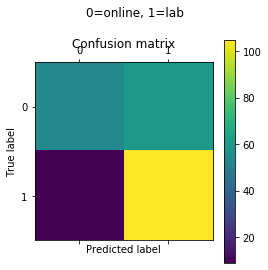

In [142]:
# Try NB model with k-cross validation

X_vectorised = CountVectorizer(token_pattern='(.*?,)').fit_transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

In [132]:
 # This seems to say that nb finds it easiest to identify lab data as lab data.
 # This makes sence as lab data is created forom an actual model and distribution rather than being created randomly.
# THen we have to consider the actual question of the dis, can we identify whos paying attention?
# Maybe say the 12ish turks falsly predicted to be labs were paying attention??
# Seems like a big leap to say that.

 # TODO do with full dataset of 300 for turks, so generate more lab data.

# Naive Bayes with N-grams

above did naive bayes on counts of items, see if looking at ngrams effects accuracy.

Accuracy: 0.69 (+/- 0.21)
f1 score: 0.93 (+/- 0.27)
accuracies:  [0.69565217 1.         1.         1.         1.        ]
f1 scores:   [0.66458333 1.         1.         1.         1.        ]
[[114   0]
 [ 14 100]]


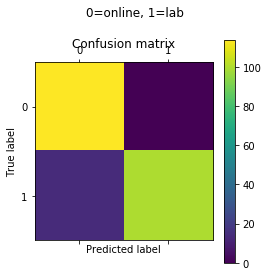

In [148]:
# Try NB model with k-cross validation

X_vectorised = CountVectorizer(token_pattern='(.*?,)', ngram_range=(2, 2)).fit_transform(X)
classifier = MultinomialNB()

scoresacc = cross_val_score(classifier, X_vectorised, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scoresf1 = cross_val_score(classifier, X_vectorised, y, cv=5, scoring='f1_macro')
print("f1 score: %0.2f (+/- %0.2f)" % (scoresf1.mean(), scoresf1.std() * 2))

print( 'accuracies: ', scoresacc )
print( 'f1 scores:  ', scoresf1 ) 

# Youre not supposed to use these predictions like this, but the cm still shows interesting information? i think
# https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn

y_pred = cross_val_predict(classifier, X_vectorised, y, cv=10)
cm = confusion_matrix(y, y_pred)
print(cm)
make_cm(cm)

In [89]:
# AMAZING!!!!!
# Very clearly can seperate the classes looking at the bigrams!!!!!

# Still questions of how to extend that to attention or not lol.
# Potentially add section on how to generate more lab data since we cant do lab studdies because of corona.

In [90]:
# Retry the log normal distribution for histograms.

In [91]:
# TODO: crossvalidataion on the models to remove the test train data split. 

In [92]:
# TODO: train NB with gen lab data, see if it classifies actual lab data as labs.

In [93]:
# TODO: maybe do the same with labs and see if the lab hmm can identify actual lab samples.

In [94]:
# TODO TODO TODO: SEE HOW MUCH LOWER LIKLIHOOD THE LAB DATAPOINTS GET ON THE TURK HMM. IF THEYRE ALL STRONG OUTLIERS (10%-20%) THEN WE CAN SAY THESE POINTS CLEARLY DONT BELONG TO THIS CLASS AND THIS IS BECAUSE AS LAB STUDY PARTICIPANTS THEYRE PAYING ATTENTION WHICH HAS CAUSED THEM TO ACT DIFFERENTLY.  

In [95]:
# Curious TODO: See if the states of the HMM relate to the sequence. for example does slider-1 actually repalte to state 1, or does it relate to state 1 and state 2 or even jsut state 6